In [30]:
import pandas as pd
import matplotlib.pyplot as plt
import os 

In [41]:
import pandas as pd
import matplotlib.pyplot as plt
import os 
dir =  os.getcwd()
FILE = dir [:-21] + "SQL/SQL_output.csv" 
df = pd.read_csv(FILE)
df if df.isna().sum(axis=1).any() else print("No missing values") 
df.rename(columns={'pizza_type_id': 'pizza_flavor'}, inplace=True) # I think this name is more appropriate
# Splitting the date into month and days
df['date'] = pd.to_datetime(df['date'])
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['day_of_week'] = df['date'].dt.day_name()
day_order = ['Sunday', 'Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday']
df['hour'] = pd.to_datetime(df['time']).dt.hour

df['order_id'] = df['month'].apply(lambda x: str(x).zfill(2)) + df['day'].apply(lambda x: str(x).zfill(2)) + df['time']

# Create 'multiple_orders' column, 1 if the order_id is duplicated, 0 if not
df['multiple_orders'] = df.duplicated('order_id').astype(int)

# Fixing typing errors in 'ingredients' column

df['ingredients'] = df['ingredients'].str.replace(', ', ',') # one space
df['ingredients'] = df['ingredients'].str.replace(',  ', ',') # two spaces after comma

# Perform one-hot encoding on the 'ingredients' column
ingredients_dummies = df['ingredients'].str.get_dummies(',')

# Add the new columns to the original DataFrame
df = pd.concat([df, ingredients_dummies], axis=1)

df = df.drop('ingredients', axis=1)
pd.set_option('display.max_columns', None)

hourly_sum_quantity = df.groupby(['day_of_week', 'hour'])['quantity'].sum()
hourly_sum_quantity




No missing values


/var/folders/8n/frf4cdjd6k134p3nvgp4kf6c0000gn/T/ipykernel_10216/2888467785.py:15: UserWarning: Could not infer format, so each element will be parsed individually, falling back to `dateutil`. To ensure parsing is consistent and as-expected, please specify a format.
  df['hour'] = pd.to_datetime(df['time']).dt.hour


day_of_week  hour
Friday       11       388
             12      1101
             13      1040
             14       525
             15       441
                     ... 
Wednesday    18       756
             19       516
             20       398
             21       271
             22       146
Name: quantity, Length: 95, dtype: int64

In [42]:
hourly_sum_quantity = hourly_sum_quantity.apply(lambda x: 4 if x > 1060 else 3 if x > 800 else 2 if x > 450 else 1 if x > 90 else 0)
hourly_sum_quantity

day_of_week  hour
Friday       11      1
             12      4
             13      3
             14      2
             15      1
                    ..
Wednesday    18      2
             19      2
             20      1
             21      1
             22      1
Name: quantity, Length: 95, dtype: int64

In [43]:
hourly_sum_quantity_df = hourly_sum_quantity.reset_index(name='desired_employee_count')
hourly_sum_quantity_df['default_employee_count'] = 2
hourly_sum_quantity_df['wage'] = 15
hourly_sum_quantity_df['difference_in_labor'] = hourly_sum_quantity_df['default_employee_count'] - hourly_sum_quantity_df['desired_employee_count']
hourly_sum_quantity_df['labor_cost_diff'] = hourly_sum_quantity_df['difference_in_labor'] * hourly_sum_quantity_df['wage']
hourly_sum_quantity_df.sum() 
#df_merged = pd.merge(df, hourly_sum_quantity_df, on=['day_of_week', 'hour'], how='left')

day_of_week               FridayFridayFridayFridayFridayFridayFridayFrid...
hour                                                                   1560
desired_employee_count                                                  166
default_employee_count                                                  190
wage                                                                   1425
difference_in_labor                                                      24
labor_cost_diff                                                         360
dtype: object

## Start of analysis

In [16]:
unique_flavors_per_category = df.groupby('category')['pizza_flavor'].nunique()
unique_flavors_per_category 

# distribution of flavors per category, veggie and supreme has the most variety

# Case 1: Higher Variety of pizzas can lead to higher sales
# but this may not be the case, as veggie and supreme 
# has the highest variety but not the highest sales

#   - this may be due to the fact that veggie and supreme are more expensive
#   - or just less popular

# Check if price for supreme and veggie is higher than classic

# if not, then the pizza's not as good and needs less variety

category
Chicken    6
Classic    8
Supreme    9
Veggie     9
Name: pizza_flavor, dtype: int64

In [17]:
df.groupby(df['category'])['quantity'].count() / df['quantity'].count() 
# percentage of each category in the total sales, seems balanced but classic is the most popular

category
Chicken    0.222439
Classic    0.299856
Supreme    0.242225
Veggie     0.235479
Name: quantity, dtype: float64

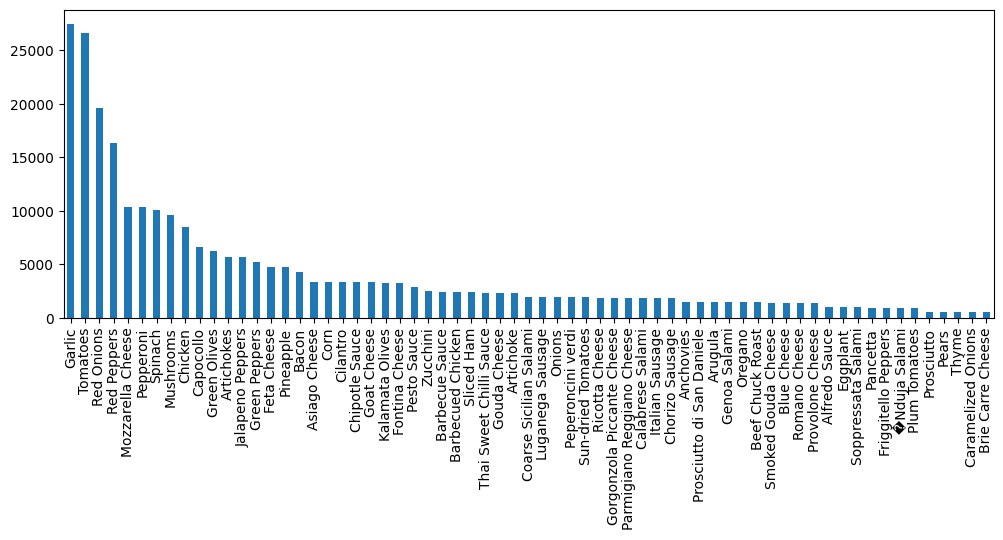

In [20]:
ing_list_ordered = ingredients.sum().sort_values(ascending=False)
ingred_plot = ing_list_ordered.plot(kind='bar', figsize=(12, 4))